In [1]:
# from subset_select_non_uniform_entropic_FISTA_git import subset_select_non_uniform_FISTA as ss
# from subset_select_ipot_non_uniform_git import subset_select_ipot as ss_ipot
import shutil
import os
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt
import random
import torch

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


:: Downsample with a voxel size 0.005.
:: Estimate normal with search radius 0.020.
:: Compute FPFH feature with search radius 0.050.


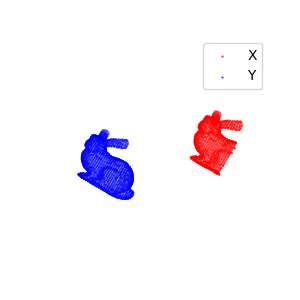

In [26]:
%matplotlib widget

voxel_size = 0.005

bunnymesh_Data = o3d.data.BunnyMesh()
bunny_mesh = o3d.io.read_triangle_mesh(bunnymesh_Data.path)
bunny_mesh.compute_vertex_normals()

pcd_mesh = o3d.io.read_point_cloud(bunnymesh_Data.path)
pcd = pcd_mesh.voxel_down_sample(voxel_size=voxel_size)

# o3d.visualization.draw_geometries([pcd])

# from open3d documentation


def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = 0.02
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = 0.05
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh


Y_pcd, Y_fpfh = preprocess_point_cloud(pcd, voxel_size=voxel_size)

Y_pc = np.asarray(Y_pcd.points)

# alph = (np.pi/12)
# Q = np.array([[np.cos(alph), -np.sin(alph), 0], [np.sin(alph),  np.cos(alph), 0], [0, 0, 1]])
# X_pc0 = Y_pc

X_pc0 = Y_pc[Y_pc[:, 0] < 0]
alph = (np.pi/6)
Q = np.array([[np.cos(alph), -np.sin(alph), 0],
             [np.sin(alph),  np.cos(alph), 0], [0, 0, 1]])
# X_pc = (X_pc0)@Q.T + 0.1
X_pc = X_pc0 + 0.2


fig = plt.figure(1, figsize=(3,3))
ax1 = fig.add_subplot(1,1, 1, projection='3d')
ax1.scatter(X_pc[:, 0], X_pc[:, 1], X_pc[:, 2], facecolor="r", label="X", s=0.2)
ax1.scatter(Y_pc[:, 0], Y_pc[:, 1], Y_pc[:, 2], facecolor="b",  label="Y", s=0.2)
ax1.set_aspect("auto")
# ax1.set_xlabel("x")
# ax1.set_ylabel("y")
# ax1.set_zlabel("z")
# ax1.set_title("X")
ax1.axis("off")
ax1.view_init(90, -60)
ax1.grid(visible=0)
ax1.legend()
# fig.savefig("bunny.pdf", dpi=500, pad_inches = 0, bbox_inches=0, format='pdf')
# fig.savefig("bunny.png", dpi=500, pad_inches = 0, bbox_inches=0, format='png')
# fig.savefig("bunny.svg", dpi=500, pad_inches = 0, bbox_inches=0, format='svg')

In [27]:
# from partial_gw import pu_gw_emd as pu_gw_emd
import ot

Cx = np.linalg.norm(X_pc - X_pc[:, None, :], axis=2)
Cy = np.linalg.norm(Y_pc - Y_pc[:, None, :], axis=2)

p = np.ones(len(Cx))/len(Cx)
q = np.ones(len(Cy))/len(Cy)

res0, log0 = ot.partial.partial_gromov_wasserstein(Cx, Cy, p, q, m=0.5, log=True, verbose=True)

# P, loss = pu_gw_emd(Cx, Cy, p, q, nb_dummies=1, group_constraints=False, G0=None, log=True, max_iter=100000)

It.  |Err         |Loss        
-------------------------------
    0|1.216466e-02|1.402228e-04
   10|6.313127e-03|2.862826e-06
   20|4.951970e-03|2.176417e-06
   30|4.415107e-03|1.793107e-06
   40|3.921867e-03|1.564335e-06
   50|2.723723e-03|1.489406e-06
   60|4.163796e-03|1.368680e-06
   70|4.495051e-03|1.212234e-06
   80|4.675206e-03|9.890850e-07
   90|2.919561e-03|8.619123e-07
  100|3.732118e-03|7.921398e-07
  110|3.979251e-03|6.642966e-07
  120|2.628799e-03|5.953907e-07
  130|1.324894e-03|5.769637e-07
  140|4.745606e-04|5.761892e-07


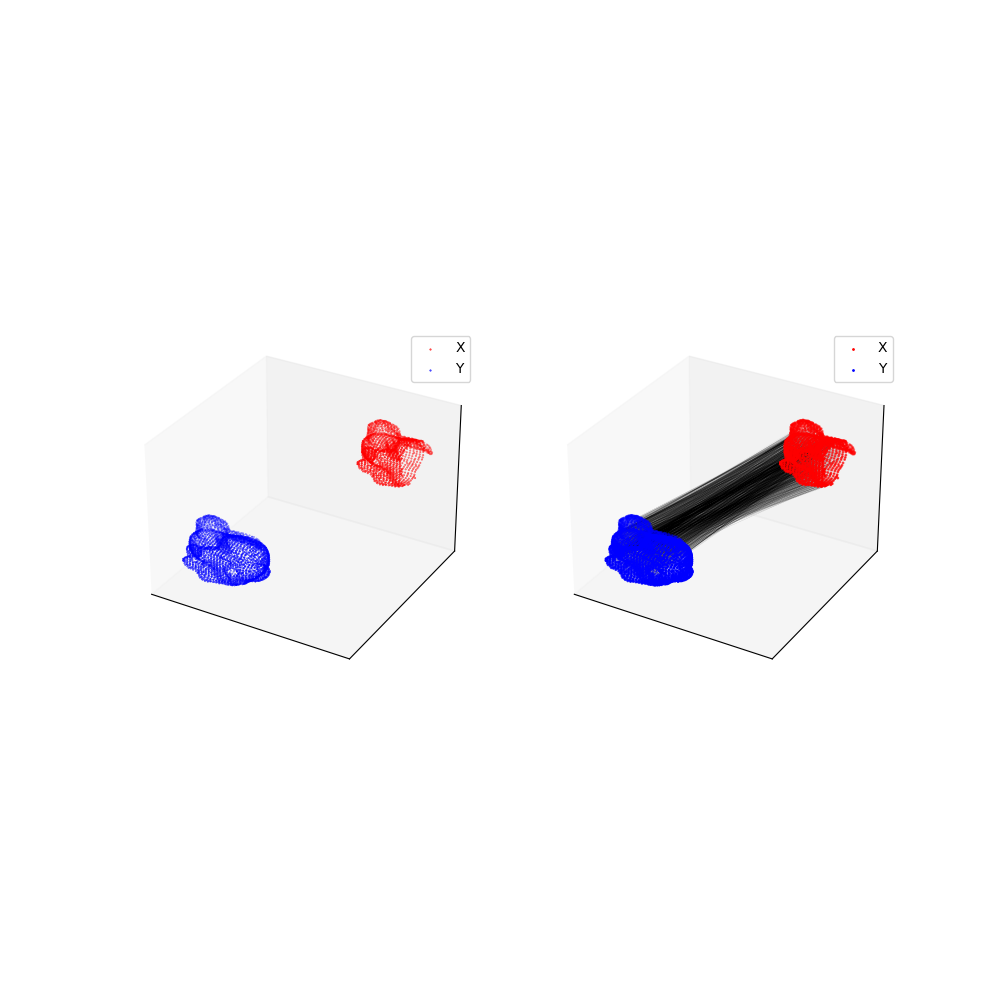

In [28]:
Xv = X_pc.T
Yv = Y_pc.T

P = res0

fig1 = plt.figure(figsize=(10,10))


ax0 = fig1.add_subplot(1, 2, 1, projection='3d')
ax0.scatter(X_pc[:, 0], X_pc[:, 1], X_pc[:, 2],
            facecolor="r", label="X", s=0.2)
ax0.scatter(Y_pc[:, 0], Y_pc[:, 1], Y_pc[:, 2],
            facecolor="b",  label="Y", s=0.2)

ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_zticks([])
ax0.legend()
ax0.tick_params(labelsize=5)

ax1= fig1.add_subplot(1, 2, 2, projection='3d')
ax1.scatter(X_pc[:, 0], X_pc[:, 1], X_pc[:, 2],facecolor="r", label="X", s=1.0)
ax1.scatter(Y_pc[:, 0], Y_pc[:, 1], Y_pc[:, 2], facecolor="b", label="Y", s=1.0)
I, J = np.nonzero(P)
for k in range(len(I)):
    ax1.plot(np.hstack((Xv[0, I[k]], Yv[0, J[k]])), np.hstack(
        ([Xv[1, I[k]], Yv[1, J[k]]])), np.hstack(
        ([Xv[2, I[k]], Yv[2, J[k]]])), 'k', lw=0.05*P[I[k], J[k]]/np.max(P), alpha=P[I[k], J[k]]/np.max(P))
# ax.axis('equal')

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.legend()
ax1.tick_params(labelsize=5)


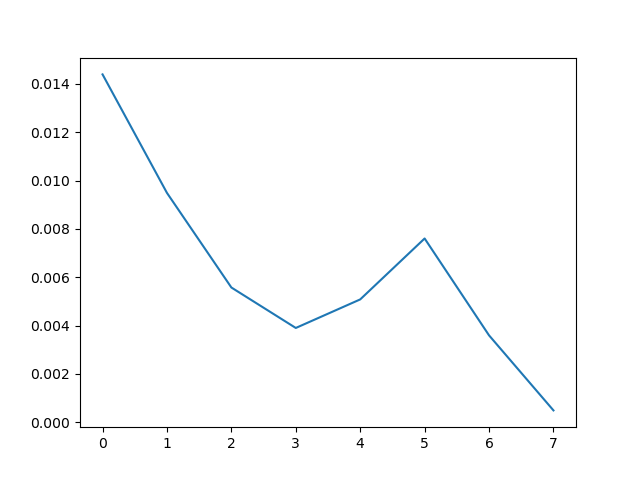

In [22]:
np.sum(P)

0.6999999999999948